
📂 Uploading kaggle.json File to Google Colab
---
This code allows us to upload the kaggle.json file, which contains your Kaggle API credentials (username and API key). These credentials are needed to download datasets directly from Kaggle.


In [4]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arpitdhumane","key":"08d5cb3bbf9f2c975ba8396702c405c0"}'}

🔐 Setting Up Kaggle API Credentials in Colab

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading the dataset for model

---



In [6]:
!kaggle datasets download -d farzadnekouei/trash-type-image-dataset

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset
License(s): unknown
  0% 0.00/40.9M [00:00<?, ?B/s]
100% 40.9M/40.9M [00:00<00:00, 1.31GB/s]


unzipping the dataset

In [ ]:
!unzip trash-type-image-dataset.zip


📦 Installing Python Libraries in Colab




In [ ]:
%pip install numpy matplotlib seaborn tensorflow scikit-learn gradio

Importing the libraries and setting up for EfficientV2B2 model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

tf.keras.mixed_precision.set_global_policy('mixed_float16')
class_names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
NUM_CLASSES=len(class_names)

:

📂 Data Preparation and Augmentation
python and setting up path and loading images from dataset


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
train_dir=r"/content/TrashType_Image_Dataset"
val_dir=r"/content/TrashType_Image_Dataset"

# Advanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load images
batch_size = 16
target_size = (224, 224)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2527 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.


Creating model , compiling it and displaying summary

In [11]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load EfficientNetV2B2 base model (without top layers)
base_model = EfficientNetV2B2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

# Freeze base model for transfer learning
base_model.trainable=False

# Add custom classification head
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
output = Dense(6, activation='sigmoid')(x)  # Sigmoid for multi-label

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary crossentropy for multi-label
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,454 (33.02 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

Addition of certain callbacks for making model trained faster

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


Class weight calculation

In [13]:
from sklearn.utils import class_weight
import numpy as np

classes = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights = dict(enumerate(class_weights))


Training the model with the given dataset

In [14]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.1767 - loss: 0.4872

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


158/158 ━━━━━━━━━━━━━━━━━━━━ 121s 502ms/step - accuracy: 0.1767 - loss: 0.4870 - val_accuracy: 0.1595 - val_loss: 0.4529 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 305ms/step - accuracy: 0.1592 - loss: 0.4617 - val_accuracy: 0.2359 - val_loss: 0.4504 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 303ms/step - accuracy: 0.1640 - loss: 0.4613 - val_accuracy: 0.2248 - val_loss: 0.4471 - learning_rate: 0.0010
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 282ms/step - accuracy: 0.1969 - loss: 0.4533 - val_accuracy: 0.1183 - val_loss: 0.4500 - learning_rate: 0.0010
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 279ms/step - accuracy: 0.1439 - loss: 0.4526 - val_accuracy: 0.2477 - val_loss: 0.4461 - learning_rate: 0.0010
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 278ms/step - accuracy: 0.1909 - loss: 0.4480 - val_accuracy: 0.1805 - val_loss: 0.4517 - learning_rate: 0.0010
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 43s 271ms/step - accuracy: 0.1428 - loss

🔄 Fine-Tuning the Model

In [15]:

base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
fine_tune_history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 288s 878ms/step - accuracy: 0.2046 - loss: 0.7675 - val_accuracy: 0.3047 - val_loss: 0.6282 - learning_rate: 1.0000e-05
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 284ms/step - accuracy: 0.2881 - loss: 0.6304 - val_accuracy: 0.3700 - val_loss: 0.5160 - learning_rate: 1.0000e-05
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 278ms/step - accuracy: 0.3399 - loss: 0.5013 - val_accuracy: 0.4539 - val_loss: 0.4339 - learning_rate: 1.0000e-05
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 284ms/step - accuracy: 0.3897 - loss: 0.4322 - val_accuracy: 0.5030 - val_loss: 0.3892 - learning_rate: 1.0000e-05
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 283ms/step - accuracy: 0.4036 - loss: 0.4068 - val_accuracy: 0.5077 - val_loss: 0.3737 - learning_rate: 1.0000e-05
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.4120 - loss: 0.3975 - val_accuracy: 0.5481 - val_loss: 0.3530 - learning_rate: 1.0000e-05
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 2

Graph of accuracy and loss

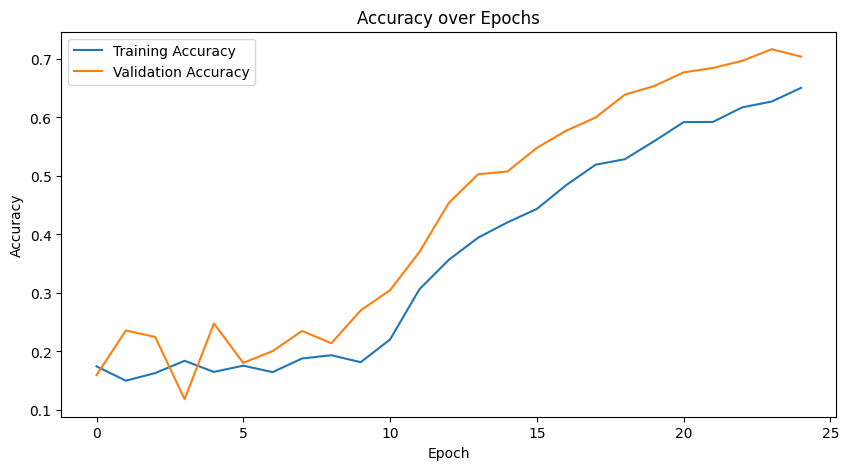

158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7205 - loss: 0.2374
Validation Accuracy: 71.67%


In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


Saving model

In [17]:
model.save("efficientnetv2b2_garbage_classifier.h5")


Displaying confusion matrix

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step


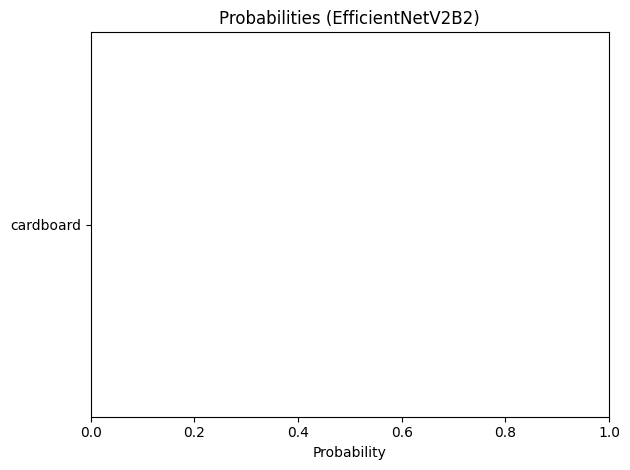

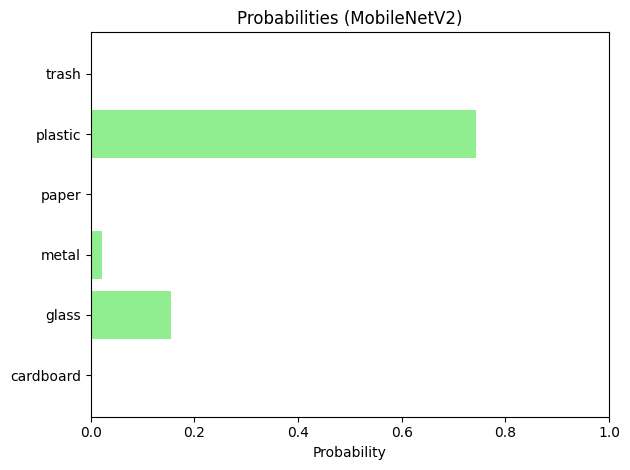

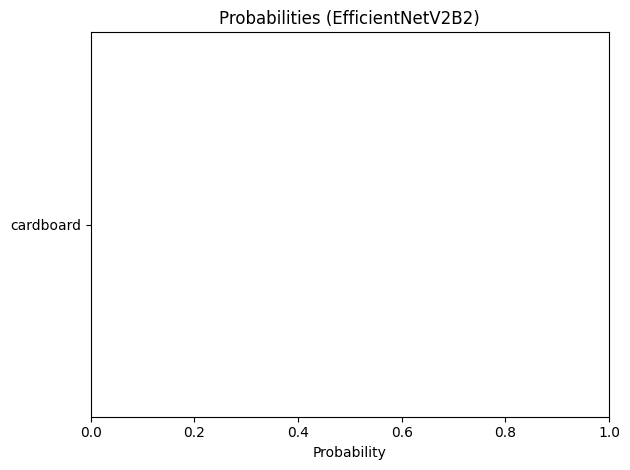

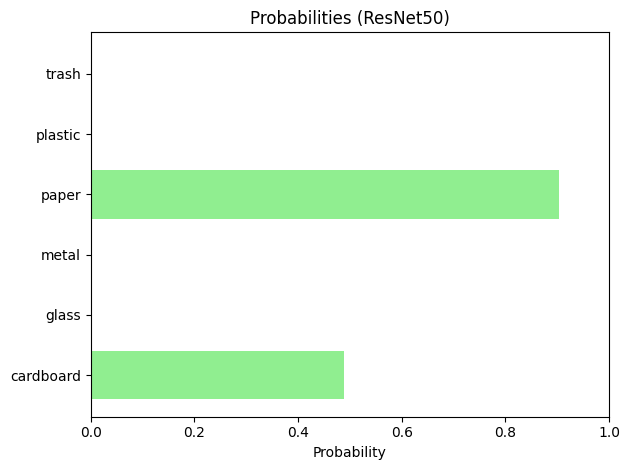

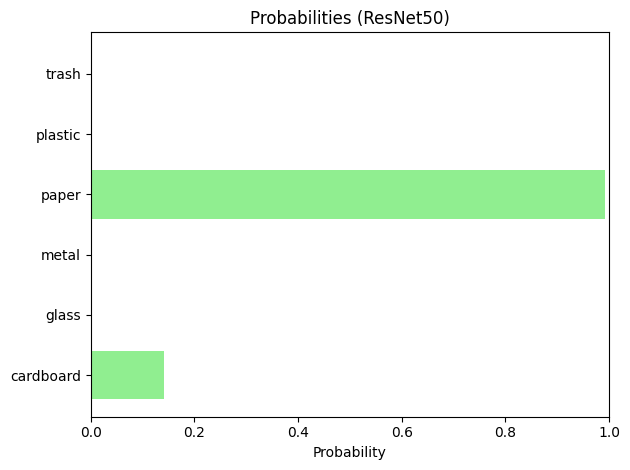

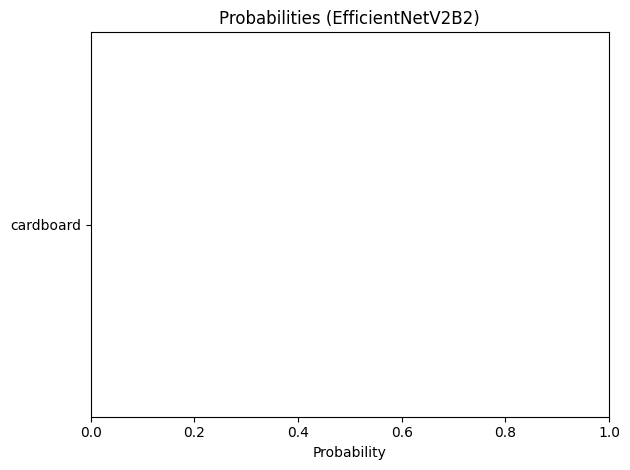

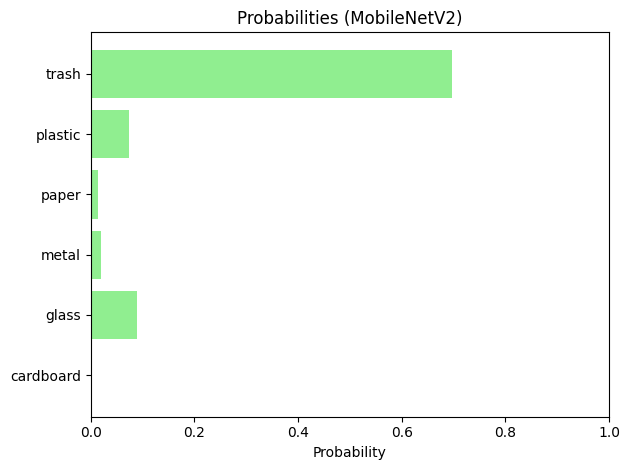

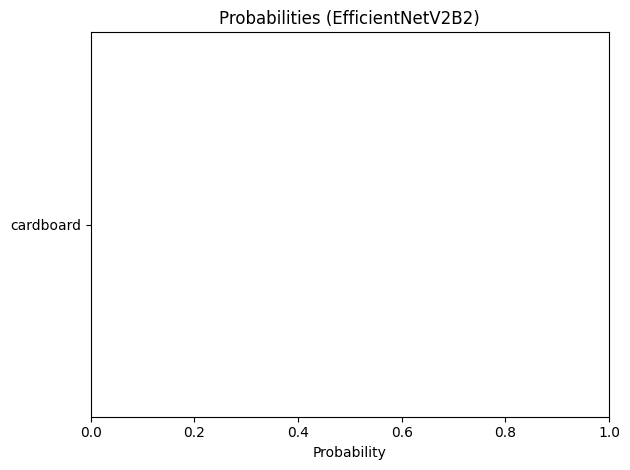

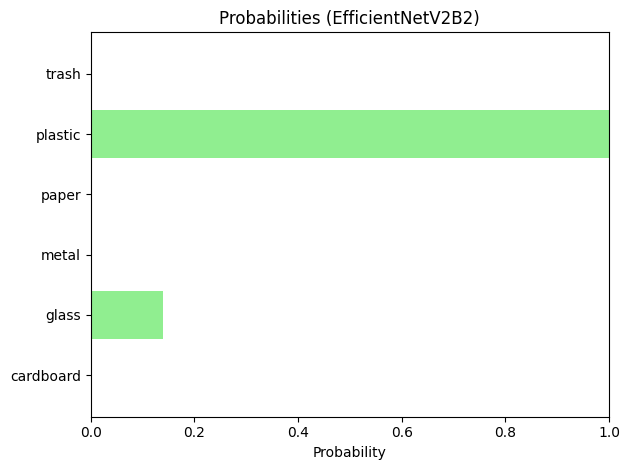

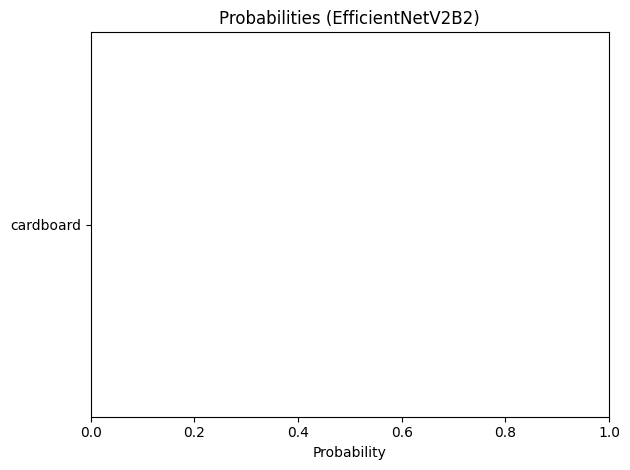

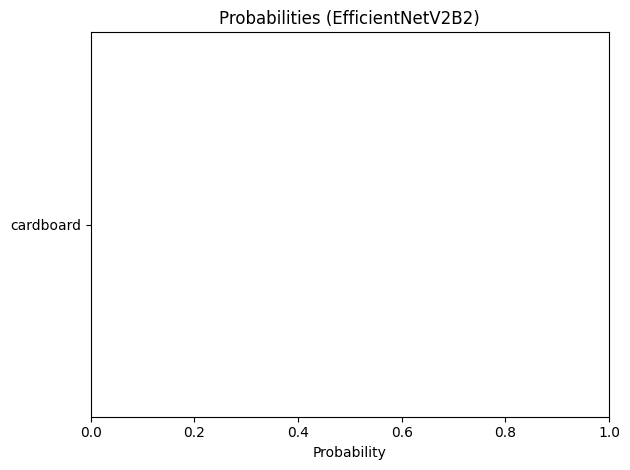

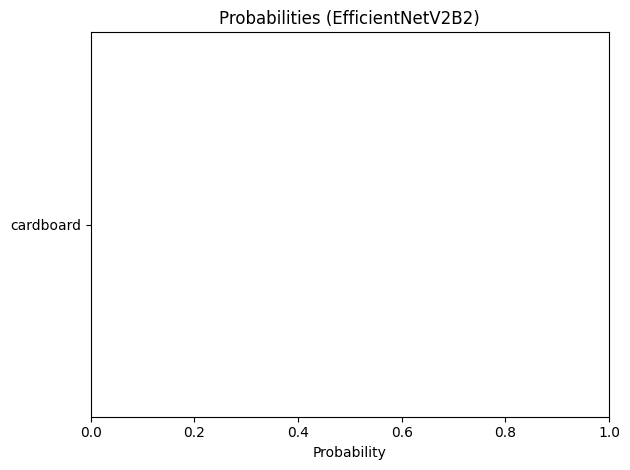

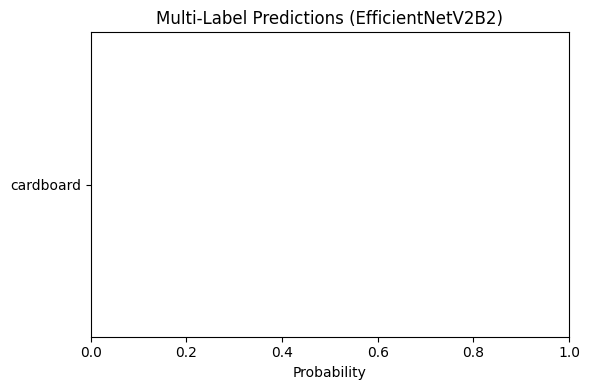

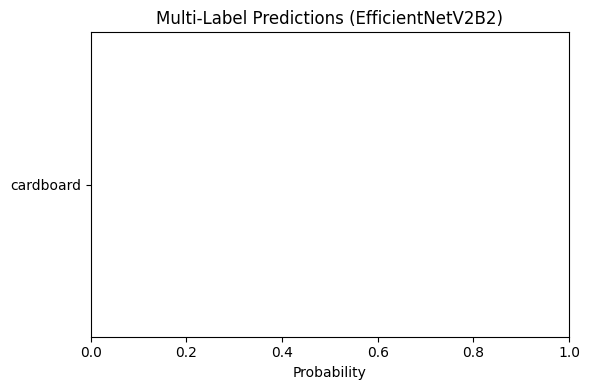

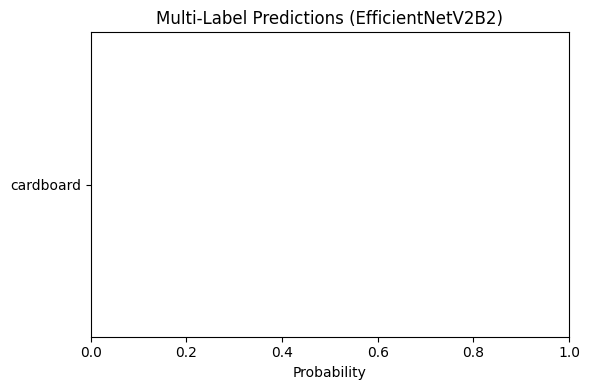

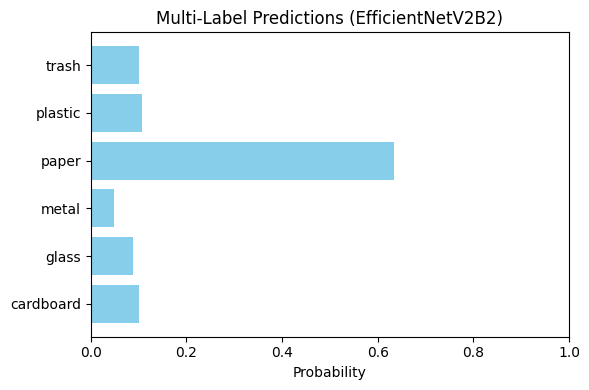

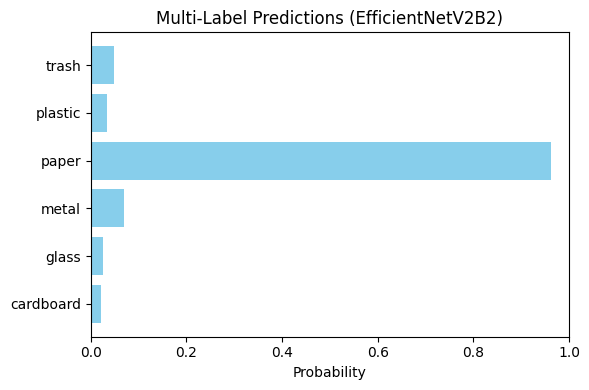

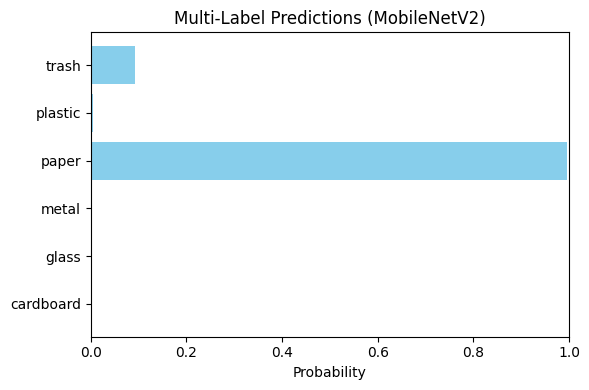

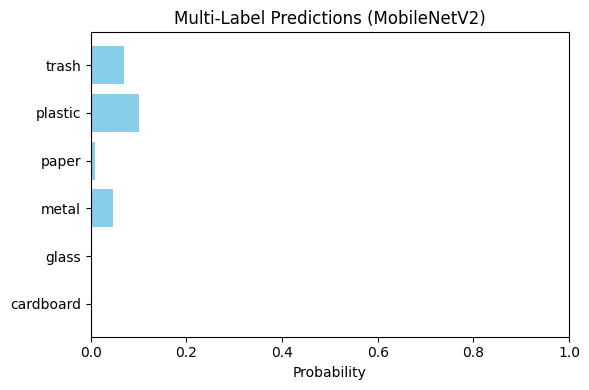

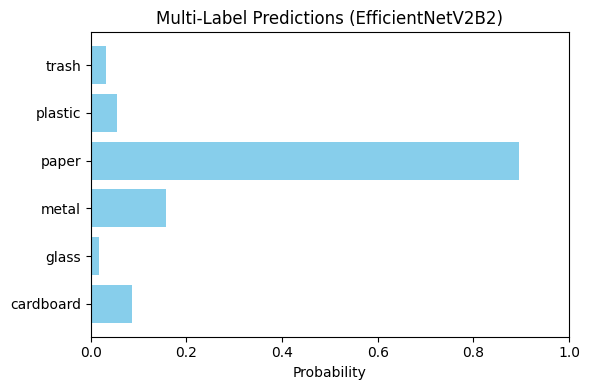

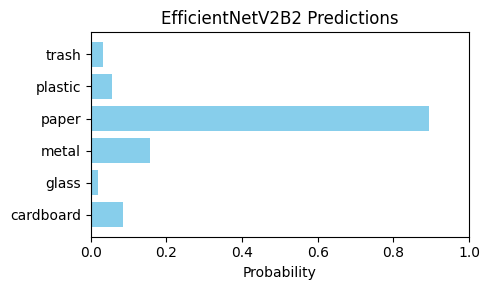

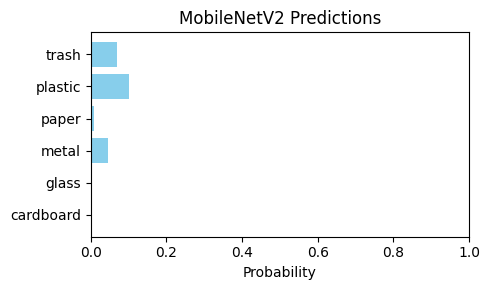

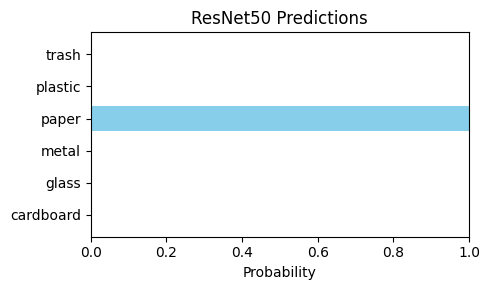

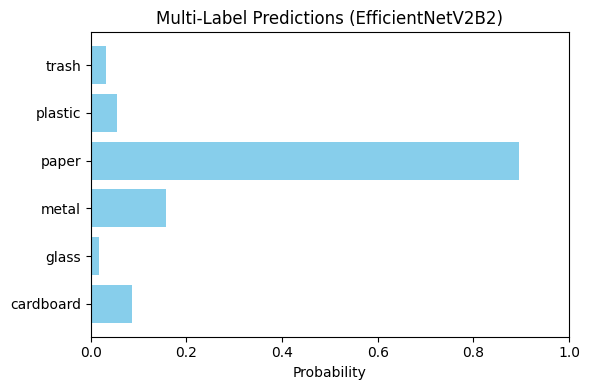

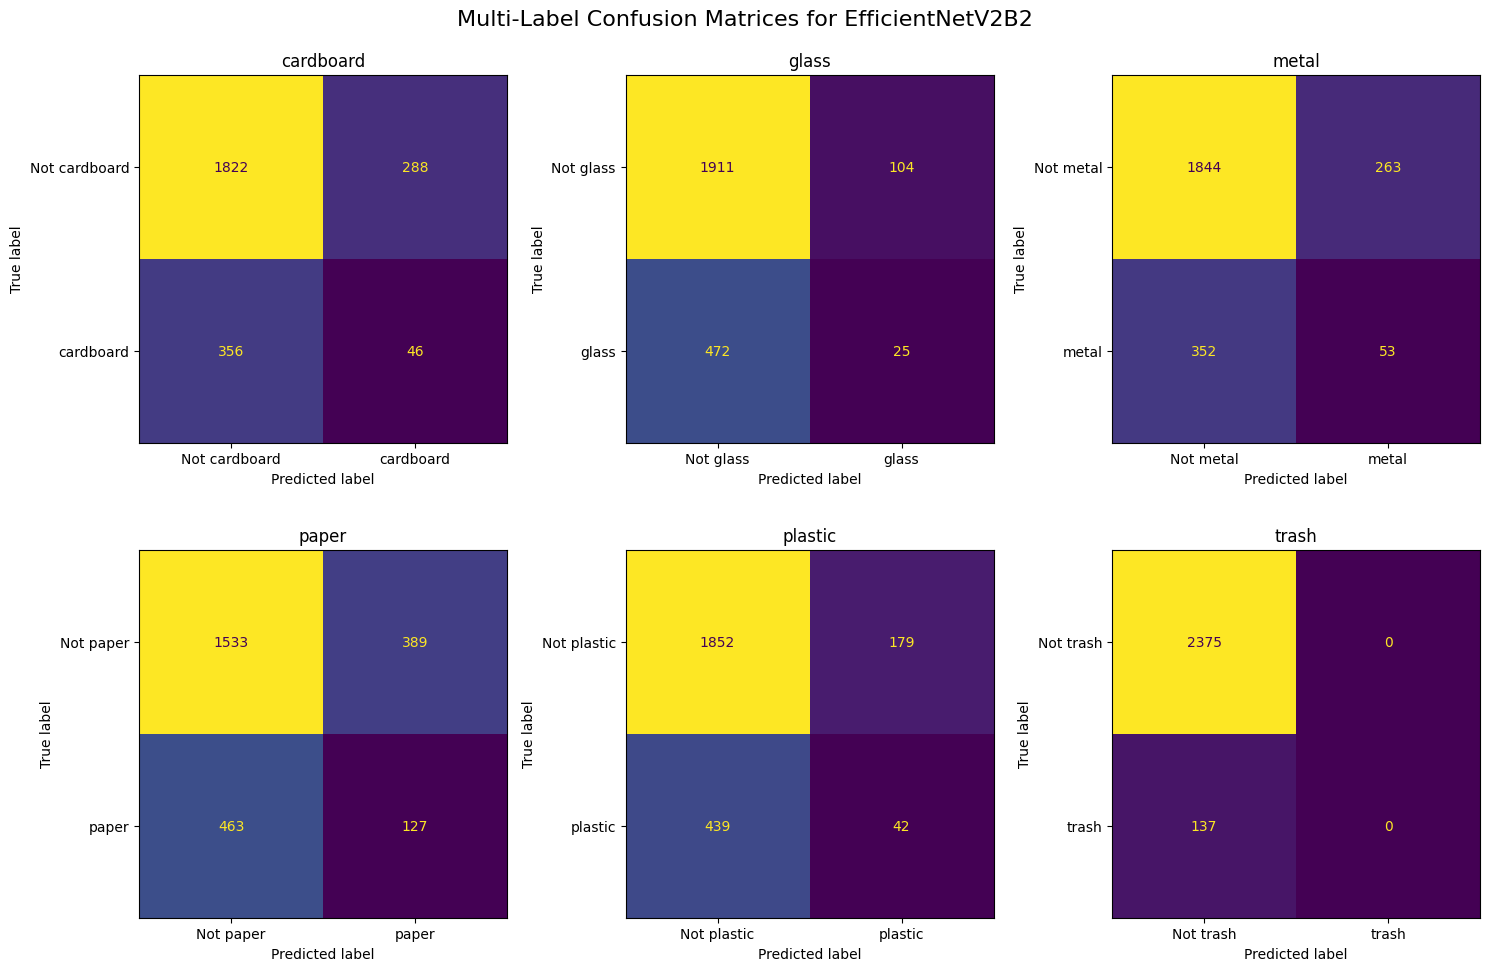

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

val_steps = val_gen.samples // val_gen.batch_size
val_preds = efficient_model.predict(val_gen, steps=val_steps, verbose=1)
val_preds_binary = (val_preds > 0.5).astype(int)
val_gen.reset()
val_labels = []
for _ in range(val_steps):
    _, labels = next(val_gen)
    val_labels.append(labels)
val_labels = np.vstack(val_labels)
cm = multilabel_confusion_matrix(val_labels, val_preds_binary)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i in range(len(class_names)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[f"Not {class_names[i]}", class_names[i]])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f"{class_names[i]}")

plt.suptitle("Multi-Label Confusion Matrices for EfficientNetV2B2", fontsize=16)
plt.tight_layout()
plt.show()


Mobilenet model

In [20]:
# MobileNetV2 Model
mobilenet_model = create_model(MobileNetV2, "imagenet", NUM_CLASSES)
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


mobilenet_model.save_weights("mobilenetv2_garbage.weights.h5")

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 61s 319ms/step - accuracy: 0.4254 - loss: 0.4177 - val_accuracy: 0.7463 - val_loss: 0.2244 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 39s 249ms/step - accuracy: 0.7106 - loss: 0.2419 - val_accuracy: 0.7942 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 39s 250ms/step - accuracy: 0.7296 - loss: 0.2185 - val_accuracy: 0.8203 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 40s 251ms/step - accuracy: 0.7712 - loss: 0.2032 - val_accuracy: 0.8294 - val_loss: 0.1605 - learning_rate: 0.0010
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 285ms/step - accuracy: 0.7745 - loss: 0.1952 - val_accuracy: 0.8381 - val_loss: 0.1543 - learning_rate: 0.0010
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.7788 - loss: 0.1881 - val_accuracy: 0.8429 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - accuracy: 0.7

ResNet50 model

In [21]:
# ResNet50 Model
resnet_model = create_model(ResNet50, "imagenet", NUM_CLASSES)
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)
resnet_model.save_weights("resnet50_garbage.weights.h5")

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 67s 336ms/step - accuracy: 0.2108 - loss: 0.5114 - val_accuracy: 0.2351 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.2497 - loss: 0.4371 - val_accuracy: 0.2928 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - accuracy: 0.2613 - loss: 0.4316 - val_accuracy: 0.2446 - val_loss: 0.4165 - learning_rate: 0.0010
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 46s 288ms/step - accuracy: 0.2743 - loss: 0.4286 - val_accuracy: 0.2984 - val_loss: 0.4157 - learning_rate: 0.0010
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.2812 - loss: 0.4255 - val_accuracy: 0.3403 - val_loss: 0.4109 - learning_rate: 0.0010
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 275ms/step - accuracy: 0.2986 - loss: 0.4182 - val_accuracy: 0.2778 - val_loss: 0.4126 - learning_rate: 0.0010
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 284ms/step - accuracy: 0.2

Creating the models

In [22]:
from tensorflow.keras.applications import EfficientNetV2B2, MobileNetV2, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

def create_model(base_model_class, weights, num_classes):
    base_model=base_model_class(include_top=False,weights=weights,input_shape=(224, 224, 3))
    base_model.trainable = False
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="sigmoid")(x)
    return Model(inputs=base_model.input, outputs=outputs)

NUM_CLASSES = 6
efficient_model = create_model(EfficientNetV2B2, "imagenet", NUM_CLASSES)
mobilenet_model = create_model(MobileNetV2, "imagenet", NUM_CLASSES)
resnet_model = create_model(ResNet50, "imagenet", NUM_CLASSES)

efficient_model.load_weights("efficientnetv2b2_garbage_classifier.h5")
mobilenet_model.load_weights("mobilenetv2_garbage.weights.h5")
resnet_model.load_weights("resnet50_garbage.weights.h5")

Gradio Interface

In [ ]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

model_dict = {
    "EfficientNetV2B2": (efficient_model, efficientnet_preprocess),
    "MobileNetV2": (mobilenet_model, mobilenet_preprocess),
    "ResNet50": (resnet_model, resnet_preprocess)
}


def classify_and_plot_multilabel(image, selected_model, threshold=0.5):
    model, preprocess_input = model_dict[selected_model]

    img = image.resize((224, 224))
    img_array = np.array(img, dtype=np.float32)
    if selected_model == "EfficientNetV2B2":
       img_array /= 255.0
    else:
       img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)[0]

    predicted_labels = [class_names[i] for i, p in enumerate(preds) if p >= threshold]
    predicted_with_probs = {class_names[i]: float(preds[i]) for i in range(len(class_names))}
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.barh(class_names, preds, color="skyblue")
    ax.set_xlim([0, 1])
    ax.set_xlabel("Probability")
    ax.set_title(f"Multi-Label Predictions ({selected_model})")
    plt.tight_layout()

    return fig, predicted_with_probs

iface = gr.Interface(
    fn=classify_and_plot_multilabel,
    inputs=[
        gr.Image(type="pil", label="Upload Image"),
        gr.Dropdown(
            choices=["EfficientNetV2B2","MobileNetV2","ResNet50"],
            value="EfficientNetV2B2",
            label="Select Model"
        ),
        gr.Slider(0.1,0.9,value=0.5,step=0.05,label="Prediction Threshold")
    ],
    outputs=[
        gr.Plot(label="Probability Bar Chart"),
        gr.Label(label="Predicted Classes")
    ],
    title="Multi-Label Garbage Classifier",
    description="Upload an image and select a model. Shows probabilities for all garbage types (supports multi-label)."
)
iface.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://795c542b1322f6448c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
